# 1. Importando as bibliotecas

In [3]:
try:
    import sys
    sys.path.append('/var/lang/lib/python37.zip')
    sys.path.append('/var/lang/lib/python3.7')
    sys.path.append('/var/lang/lib/python3.7/lib-dynload')
    sys.path.append('/var/lang/lib/python3.7/site-packages')
    sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')
except:
    pass

In [45]:
import pandas as pd
import boto3
import io
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score, confusion_matrix, auc

# 2. Importando os dados ja processados do AWS S3{

In [46]:
s3_client = boto3.client('s3')
obj = s3_client.get_object(Bucket=bucket, Key = 'databases/treinamento_validacao_modelo2/train_data.csv')
df_train = pd.read_csv(io.BytesIO(obj['Body'].read()))

In [47]:
s3_client = boto3.client('s3')
obj = s3_client.get_object(Bucket=bucket, Key = 'databases/treinamento_validacao_modelo2/test_data.csv')
df_test = pd.read_csv(io.BytesIO(obj['Body'].read()))

# 3. Separando as variaveis preditoras da variavel target nos dados de treino

In [48]:
X_train = df_train.drop(['target', 'id'], axis =1)
y_train = df_train['target']

# 4. Separando as variaveis preditoras da variavel target nos dados de teste

In [49]:
X_test = df_test.drop(['target', 'id'], axis =1)
y_test = df_test['target']

# 5. Recriando o modelo para realizar analise. (obs: Nao consegui importar o modelo que foi treinado com o Sagemaker.Scikit.Estimator para a extesao .joblib ou .pkl para fazer a analise do modelo utilizando o modelo ja treinado)

In [100]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [101]:
y_pred = model.predict(X_test)

# 6. Visualizando os Kpi's do modelo

In [71]:
Kpi = classification_report(y_test, y_pred, target_names=['Saudavel','Doente '])
print(Kpi)

              precision    recall  f1-score   support

    Saudavel       0.90      0.76      0.82       310
     Doente        0.79      0.91      0.85       305

    accuracy                           0.84       615
   macro avg       0.84      0.84      0.84       615
weighted avg       0.84      0.84      0.83       615



# 7. Calculando o valor da area sobre a curva ROC e a curva ROC

In [72]:
model_prob = model.predict_proba(X_test)
prob = model_prob[:, 1]
rfp, rvp,lim = roc_curve(y_test, prob)
roc_auc_score(y_test, prob)

0.9074669487043893

# 8. Plotando o grafico da curva ROC 

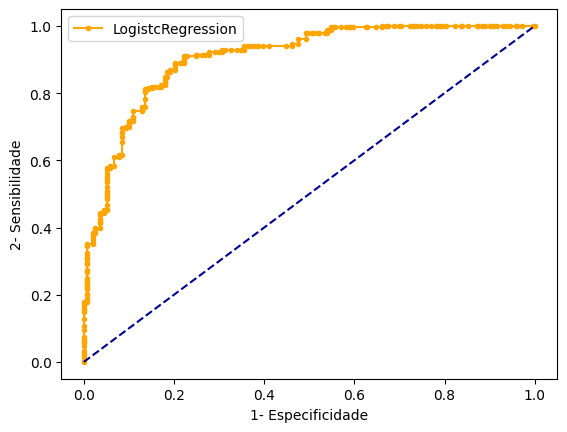

In [73]:
plt.plot(rfp, rvp, marker='.', label='LogistcRegression',color="orange")
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('1- Especificidade')
plt.ylabel('2- Sensibilidade')
plt.legend()
plt.show()

# 9. Atribuindo um ponte de corte e calculando a curva e o valor da area considerando o ponto de corte

In [94]:
thresh = 0.67

In [95]:
y_pred_thresh=binarize(model_prob,threshold= thresh )[:,1]
y_pred_thresh = (y_pred_thresh > thresh).astype(int)
rfp, rvp,lim = roc_curve(y_test, y_pred_thresh)
roc_auc_score(y_test, y_pred_thresh)

0.8355367530407192

# 10. Plotando a curva ROC considerando o ponto de corte

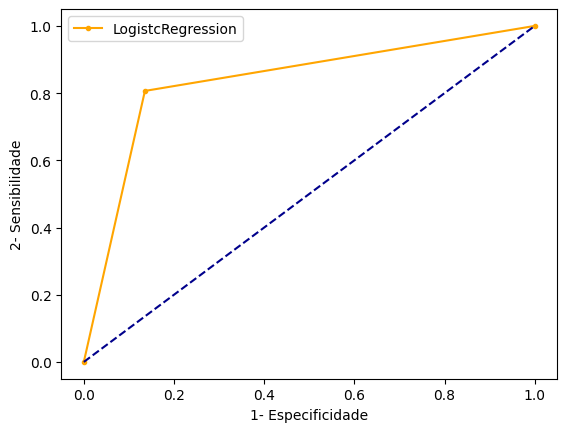

In [96]:
plt.plot(rfp, rvp, marker='.', label='LogistcRegression',color="orange")
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('1- Especificidade')
plt.ylabel('2- Sensibilidade')
plt.legend()
plt.show()

In [97]:
joblib.dump(model,  "model.joblib")

['model.joblib']